# **Experiment Notebook**



In [114]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [115]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [116]:
from brayam_pineda_ml import DataLoader, ModelTrainer, ModelEvaluator, Predictor, parse_height_to_cm

In [117]:
# <Student to fill this section>
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import joblib

---
## A. Project Description


In [118]:
# <Student to fill this section>
student_name = "Brayam Alexander Pineda"
student_id = "25587799"
group_id = "26"

In [119]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [120]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

In [121]:
# Do not modify this code
print_tile(size="h1", key='group_id', value=group_id)

---
## B. Business Understanding

In [122]:
# <Student to fill this section>
business_use_case_description = """
The goal of this project is to develop a machine learning model that accurately predicts the likelihood of a college basketball player being drafted into the NBA. By analyzing player performance statistics from the current season, the model will produce probability scores that reflect how likely each athlete is to be selected by a team.
"""

In [123]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [124]:
# <Student to fill this section>
business_objectives = """
Accurate predictions can lead to better drafting strategies, more efficient use of scouting resources, and increased competitive advantage for NBA teams. On the other hand, inaccurate results may cause teams to overlook high-potential players or waste draft picks on less qualified candidates. Therefore, the model’s reliability is critical, not just for performance, but for fairness, reputation, and long-term trust in AI-driven sports analytics.
"""

In [125]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [126]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
The primary users of the model predictions will be NBA team decision-makers, including scouts and general managers, who can integrate these insights into their draft strategies. Additionally, college programs, player agents, and sports analysts may use the results to track potential draftees and support players’ development and exposure. The predictions may impact athletes directly by influencing perceptions of their draftability, as well as teams by affecting draft choices, competitive outcomes, and financial investments."""

In [127]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [128]:
data_loader = DataLoader()
all_datasets = data_loader.load_raw_datasets()

2025-08-28 22:31:08.467 | INFO     | brayam_pineda_ml.data_loader:__init__:86 - DataLoader initialized with data folder: ../data/raw
2025-08-28 22:31:08.483 | INFO     | brayam_pineda_ml.data_loader:load_raw_datasets:131 - Loaded dataset 'test' with shape (1297, 61)
2025-08-28 22:31:08.485 | INFO     | brayam_pineda_ml.data_loader:load_raw_datasets:131 - Loaded dataset 'metadata' with shape (62, 3)
2025-08-28 22:31:08.669 | INFO     | brayam_pineda_ml.data_loader:load_raw_datasets:131 - Loaded dataset 'train' with shape (14774, 62)
2025-08-28 22:31:08.672 | INFO     | brayam_pineda_ml.data_loader:load_raw_datasets:131 - Loaded dataset 'sample_submission' with shape (1297, 2)


In [129]:
metadata = all_datasets['metadata']
test_set = all_datasets['test']
train_set = all_datasets['train']

In [130]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14774 entries, 0 to 14773
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 14774 non-null  object 
 1   conf                 14774 non-null  object 
 2   GP                   14774 non-null  int64  
 3   Min_per              14774 non-null  float64
 4   Ortg                 14774 non-null  float64
 5   usg                  14774 non-null  float64
 6   eFG                  14774 non-null  float64
 7   TS_per               14774 non-null  float64
 8   ORB_per              14774 non-null  float64
 9   DRB_per              14774 non-null  float64
 10  AST_per              14774 non-null  float64
 11  TO_per               14774 non-null  float64
 12  FTM                  14774 non-null  int64  
 13  FTA                  14774 non-null  int64  
 14  FT_per               14774 non-null  float64
 15  twoPM                14774 non-null 

In [131]:
train_set['drafted'].value_counts()

drafted
0.0    14656
1.0      118
Name: count, dtype: int64

In [132]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 1297 non-null   object 
 1   conf                 1297 non-null   object 
 2   GP                   1297 non-null   int64  
 3   Min_per              1297 non-null   float64
 4   Ortg                 1297 non-null   float64
 5   usg                  1297 non-null   float64
 6   eFG                  1297 non-null   float64
 7   TS_per               1297 non-null   float64
 8   ORB_per              1297 non-null   float64
 9   DRB_per              1297 non-null   float64
 10  AST_per              1297 non-null   float64
 11  TO_per               1297 non-null   float64
 12  FTM                  1297 non-null   int64  
 13  FTA                  1297 non-null   int64  
 14  FT_per               1297 non-null   float64
 15  twoPM                1297 non-null   i

In [133]:
# Check for repeated player_id within each dataset
print("Checking for duplicate player_id within each dataset:")
for name, df in [('train_set', train_set), ('test_set', test_set)]:
    num_duplicates = df['player_id'].duplicated().sum()
    if num_duplicates > 0:
        print(f"  {name}: {num_duplicates} duplicate player_id(s) found.")
    else:
        print(f"  {name}: No duplicate player_id found.")

# Check for player_id overlap between train_set and test_set
train_ids = set(train_set['player_id'])
test_ids = set(test_set['player_id'])
overlap_ids = train_ids.intersection(test_ids)
print(f"\nNumber of player_id present in both train_set and test_set: {len(overlap_ids)}")
if len(overlap_ids) > 0:
    print("Sample overlapping player_id(s):", list(overlap_ids)[:10])


Checking for duplicate player_id within each dataset:
  train_set: 2619 duplicate player_id(s) found.
  test_set: No duplicate player_id found.

Number of player_id present in both train_set and test_set: 0


In [134]:
train_set['player_id'].value_counts()

player_id
e5876a17-fc6c-4b43-8367-f421b26db445    4
0a30a92c-0ac2-4e2d-8f17-43dd3f8f3816    4
4302901d-ae1d-49e8-80e0-97e6cff386af    4
a1a06d07-12ae-4dfd-b295-011484a648d4    4
8233e6a9-0859-4acb-be06-face92bc6645    3
                                       ..
bff9abb4-f8b5-46e6-b8e0-81189d1939ad    1
bb1df024-0441-4d91-a2f0-436f1b77e36b    1
3b5b6074-3323-43a7-91ae-29030aa788e1    1
d853e9ec-24c0-4e9e-b783-3935a456156c    1
5b3c7231-7995-4107-b8fa-c3059a1710e5    1
Name: count, Length: 12155, dtype: int64

In [135]:
train_set[train_set['player_id'] == "e5876a17-fc6c-4b43-8367-f421b26db445"][["team", "year", "drafted"]]

,team,year,drafted
7493,Missouri St.,2015,0.0
8591,Missouri St.,2016,0.0
13748,Missouri St.,2015,0.0
14511,Missouri St.,2016,0.0


In [136]:
subset = train_set[(train_set['player_id'] == "e5876a17-fc6c-4b43-8367-f421b26db445") & (train_set['team'] == "Missouri St.") & (train_set['year'] == 2015)]
unique_cols = [col for col in subset.columns if subset[col].nunique() > 1]
subset[unique_cols]

""
7493
13748


There are repeated students (player_id). A player can apply to many different teams in the same year or at the same team several times in the same year, but they can also apply again in subsequent years. It appears that in each application per year, their statistics remain the same.
For example: 

* "a1a06d07-12ae-4dfd-b295-011484a648d4", 
* "e5876a17-fc6c-4b43-8367-f421b26db445" (this player applied to the same team twice in the same year).

In [137]:
# Remove duplicates by player_id, team, and year in train_set and test_set
train_set = train_set.drop_duplicates(subset=['player_id', 'team', 'year'])
test_set = test_set.drop_duplicates(subset=['player_id', 'team', 'year'])


### C.2 Define Target variable

In [138]:
# <Student to fill this section>
target_definition_explanations = """
The chosen target variable is drafted, a binary indicator of whether a player was selected in the NBA draft.
"""

In [139]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [140]:
# <Student to fill this section>

target_name = 'drafted'

### C.4 Explore Target variable

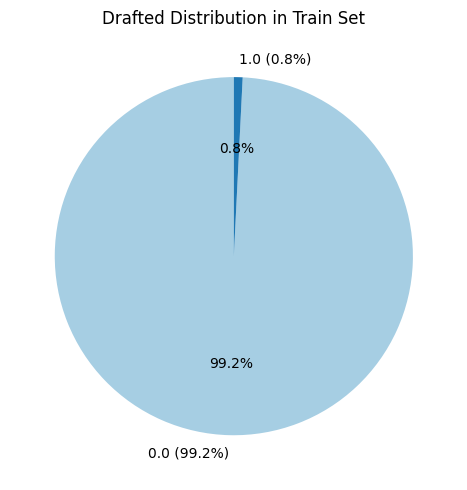

In [141]:
# Pie plot for train_set only, since test_set does not have the target
train_counts = train_set['drafted'].value_counts()
train_labels = train_counts.index.astype(str)
train_sizes = train_counts.values
train_percentages = [f'{p:.1f}%' for p in 100 * train_sizes / train_sizes.sum()]

fig, ax = plt.subplots(figsize=(6, 5))

ax.pie(
    train_sizes, 
    labels=[f"{label} ({perc})" for label, perc in zip(train_labels, train_percentages)],
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Paired.colors
)
ax.set_title('Drafted Distribution in Train Set')

plt.tight_layout()
plt.show()


In [142]:
train_set['drafted'].value_counts(), test_set.shape[0]

(drafted
 0.0    12215
 1.0       97
 Name: count, dtype: int64,
 1297)

In [143]:
# Analyze the distribution of 'drafted' across categorical variables with <= 10 unique values

# Identify categorical columns (object or category dtype)
cat_cols = train_set.select_dtypes(include=['object', 'category']).columns.tolist()

# Also consider integer columns with few unique values as categorical
for col in train_set.select_dtypes(include=['int', 'int64', 'float', 'float64']).columns:
    if train_set[col].nunique() <= 10 and col != 'drafted':
        cat_cols.append(col)

# Remove duplicates and the target variable itself if present
cat_cols = list(set(cat_cols) - {'drafted'})

for col in cat_cols:
    n_unique = train_set[col].nunique()
    if n_unique > 10:
        print(f"Column '{col}' has {n_unique} unique values. Skipping.")
        continue
    print(f"\nDistribution of 'drafted' across '{col}' ({n_unique} unique values):")
    display(
        train_set.groupby(col)['drafted'].value_counts(normalize=True).unstack(fill_value=0).style.format("{:.2%}")
    )



Distribution of 'drafted' across 'year' (10 unique values):


drafted,0.000000,1.000000
year,,
2009,99.69%,0.31%
2010,99.20%,0.80%
2011,99.49%,0.51%
2012,99.36%,0.64%
2013,99.41%,0.59%
2014,99.26%,0.74%
2015,99.00%,1.00%
2016,98.98%,1.02%
2017,98.86%,1.14%


Column 'conf' has 36 unique values. Skipping.

Distribution of 'drafted' across 'yr' (1 unique values):


drafted,0.000000,1.000000
yr,,
Fr,99.21%,0.79%


Column 'player_id' has 12155 unique values. Skipping.
Column 'team' has 355 unique values. Skipping.

Distribution of 'drafted' across 'type' (1 unique values):


drafted,0.000000,1.000000
type,,
all,99.21%,0.79%


In [144]:
# <Student to fill this section>
target_distribution_explanations = """
The target variable drafted represents whether a player was selected in the NBA draft. The data exhibits a significant class imbalance, with only 0.8% of players being drafted. This imbalance is consistent across all years in the dataset. Such an extreme skew presents a major challenge for classification, as models may favor the majority class and fail to capture meaningful signals from the minority class. Therefore, careful modeling strategies, such as resampling techniques, class weighting, and performance evaluation with AUROC, are necessary to build a reliable and fair predictive system.
"""

In [145]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `bivariate_analysis`

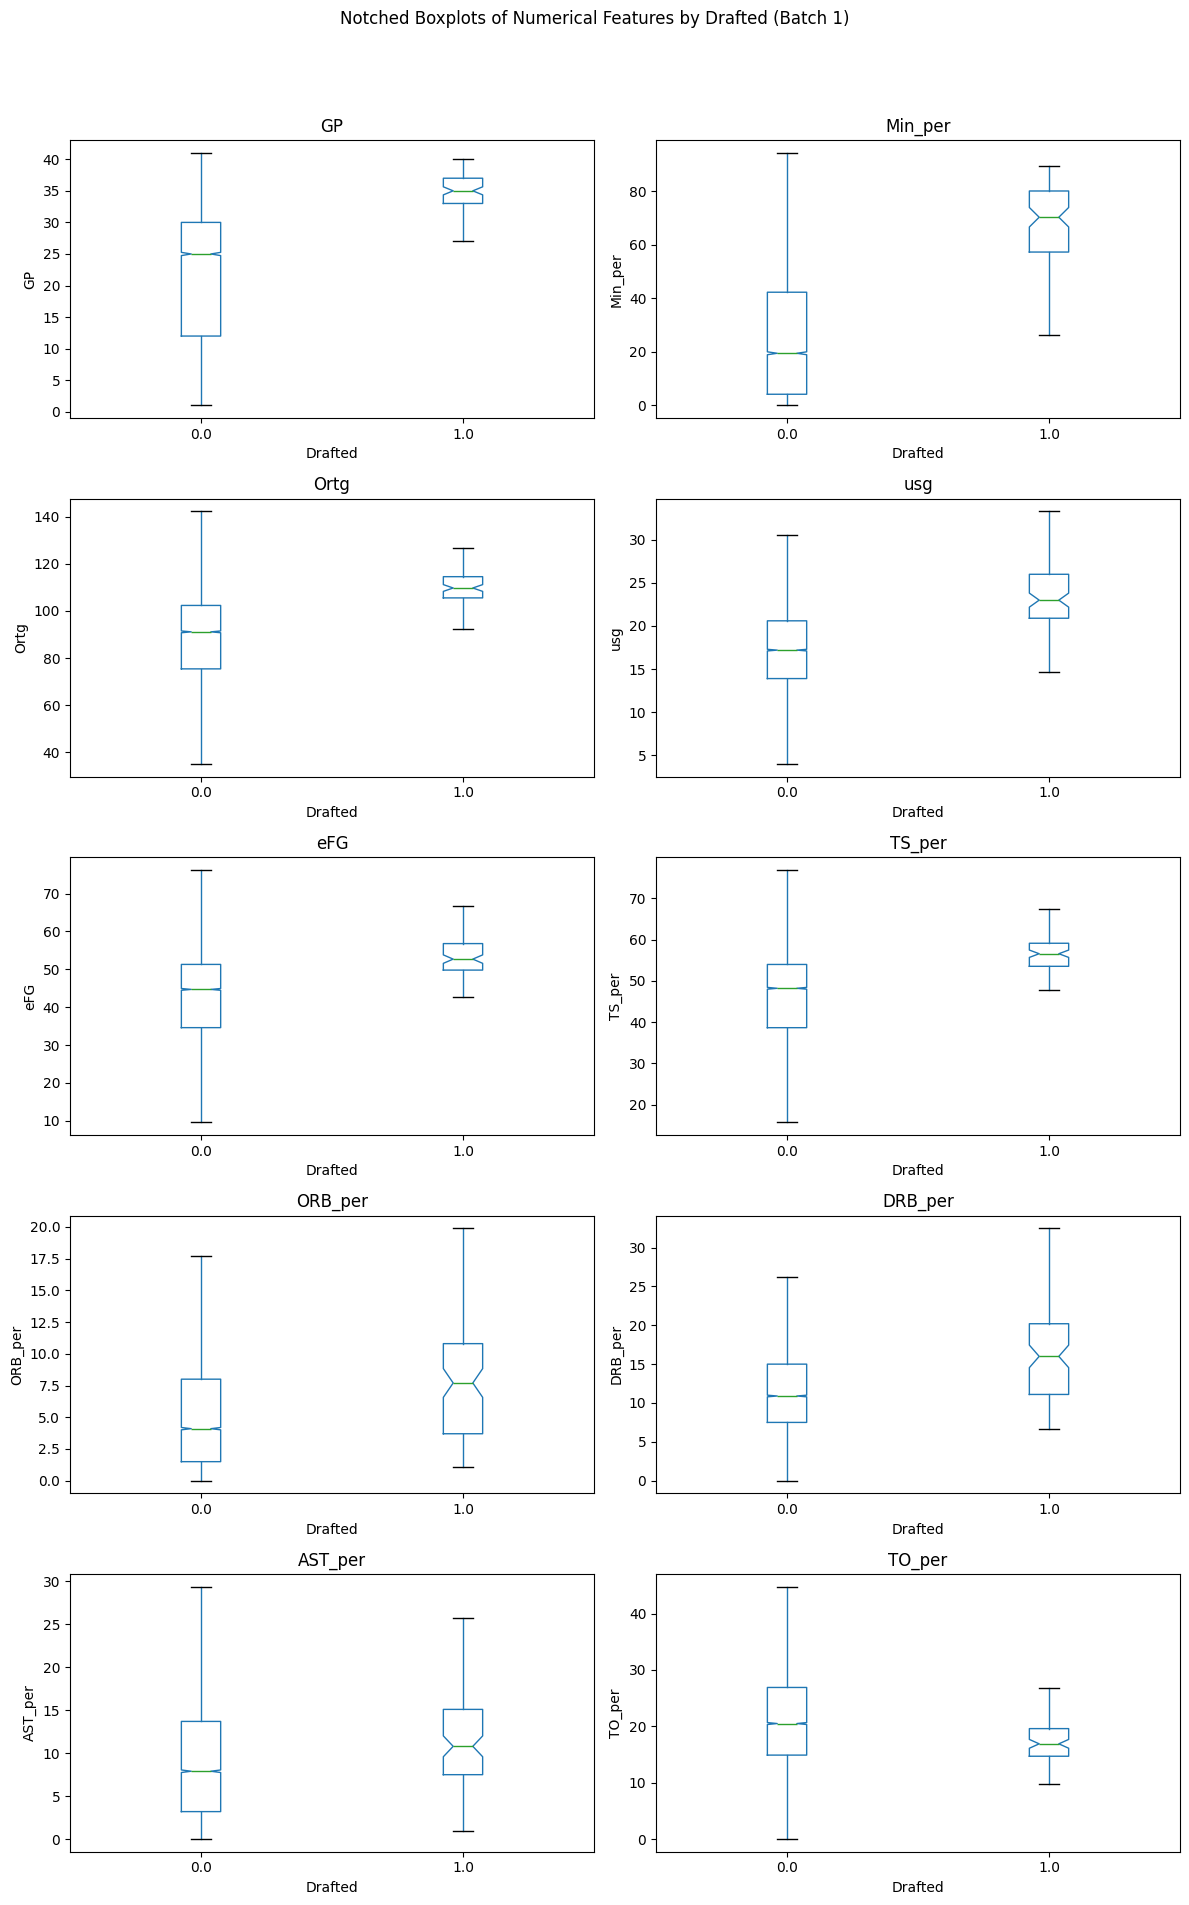

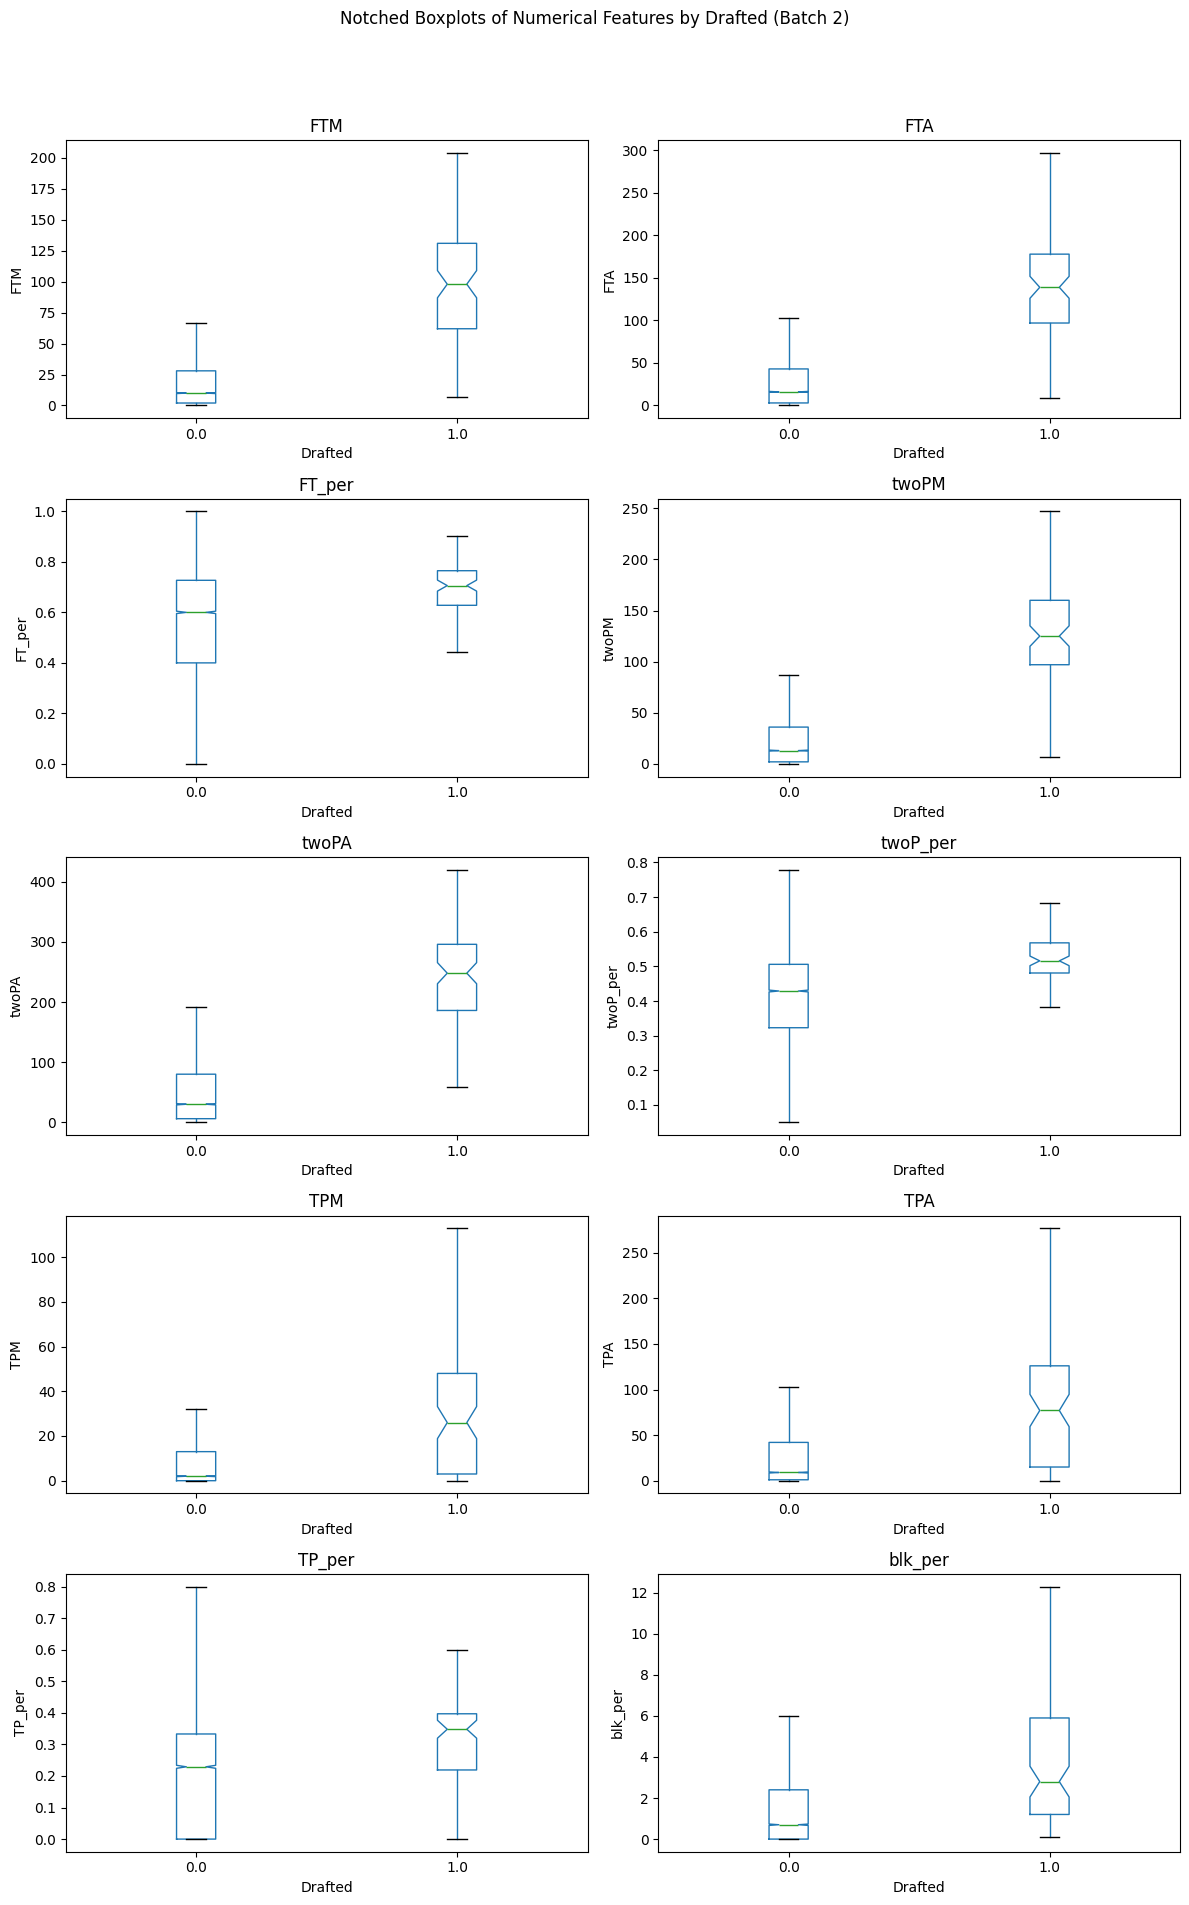

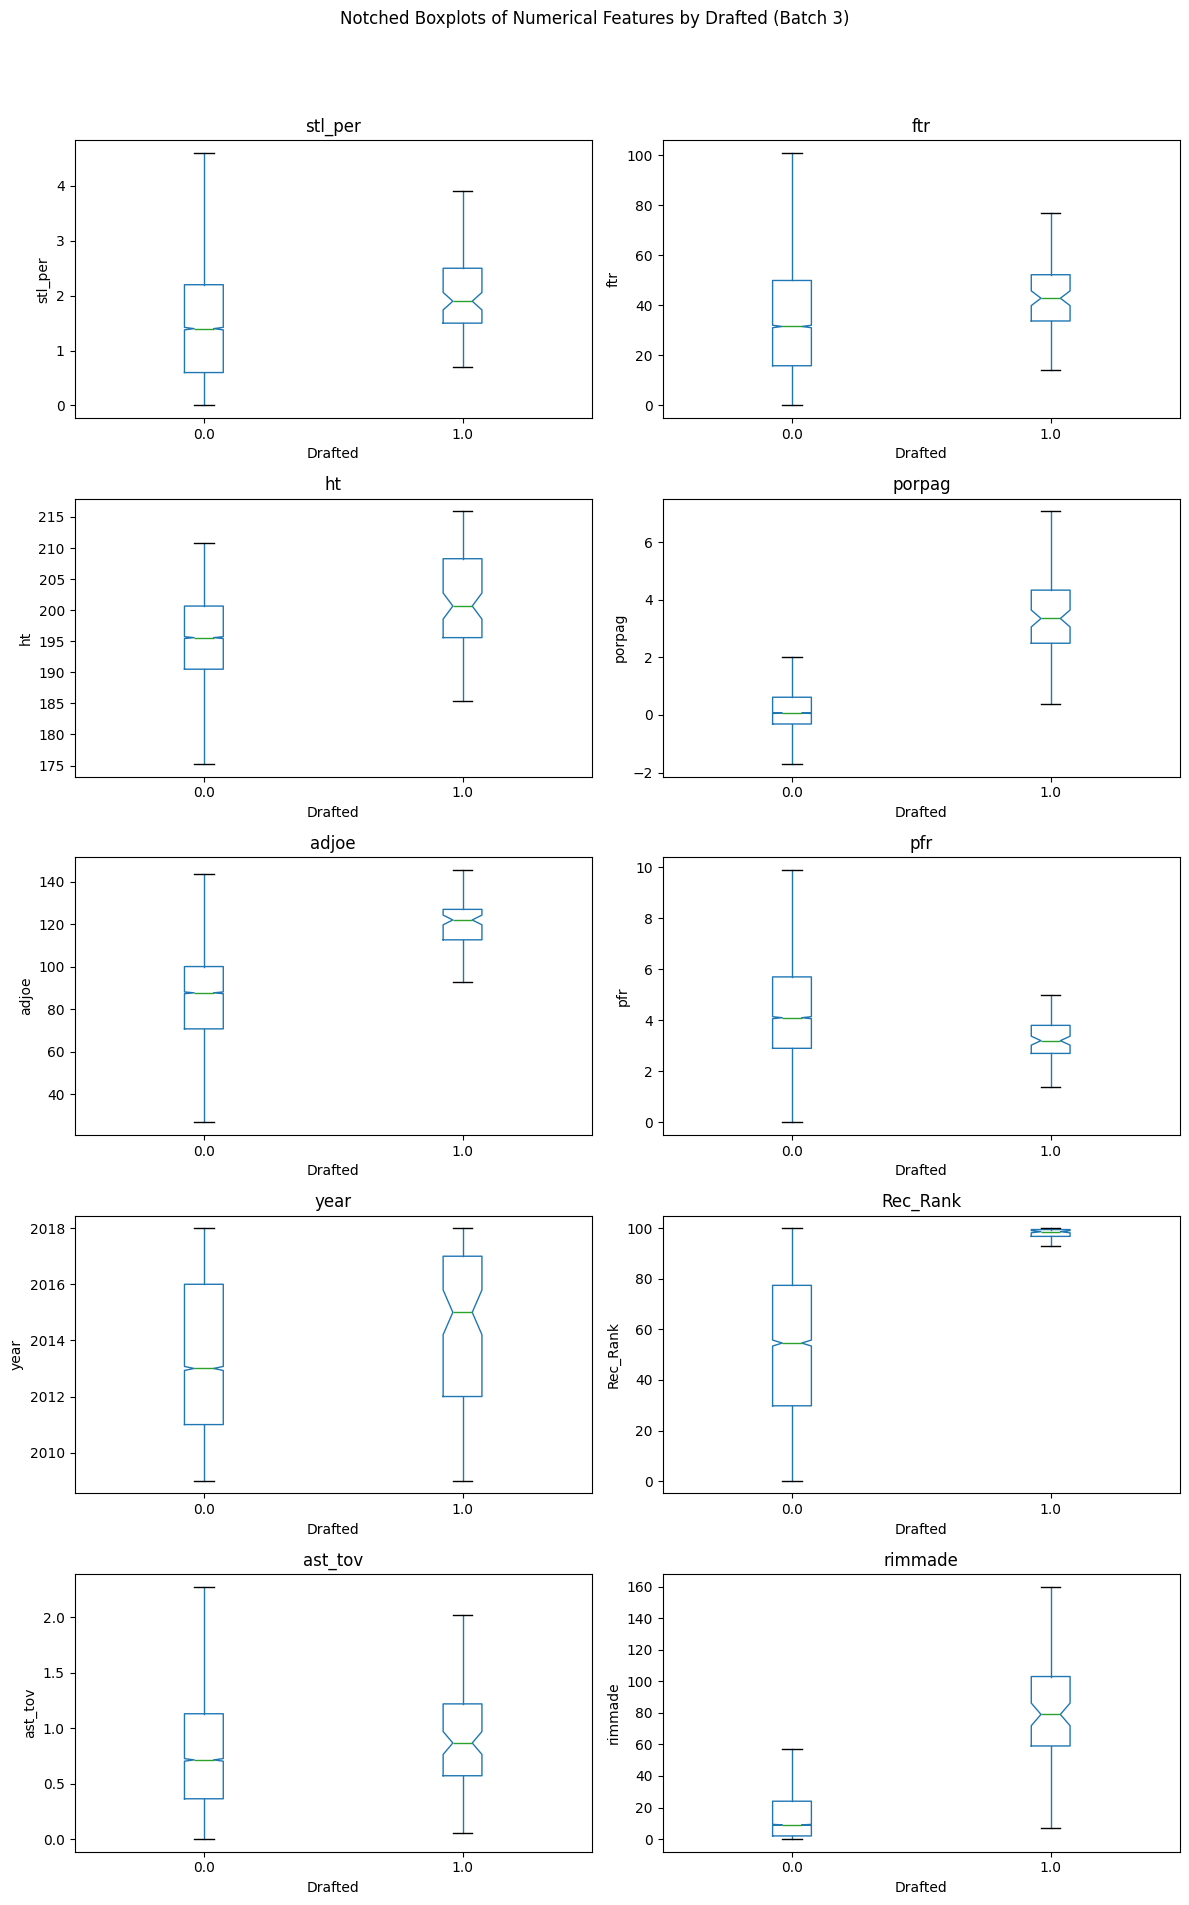

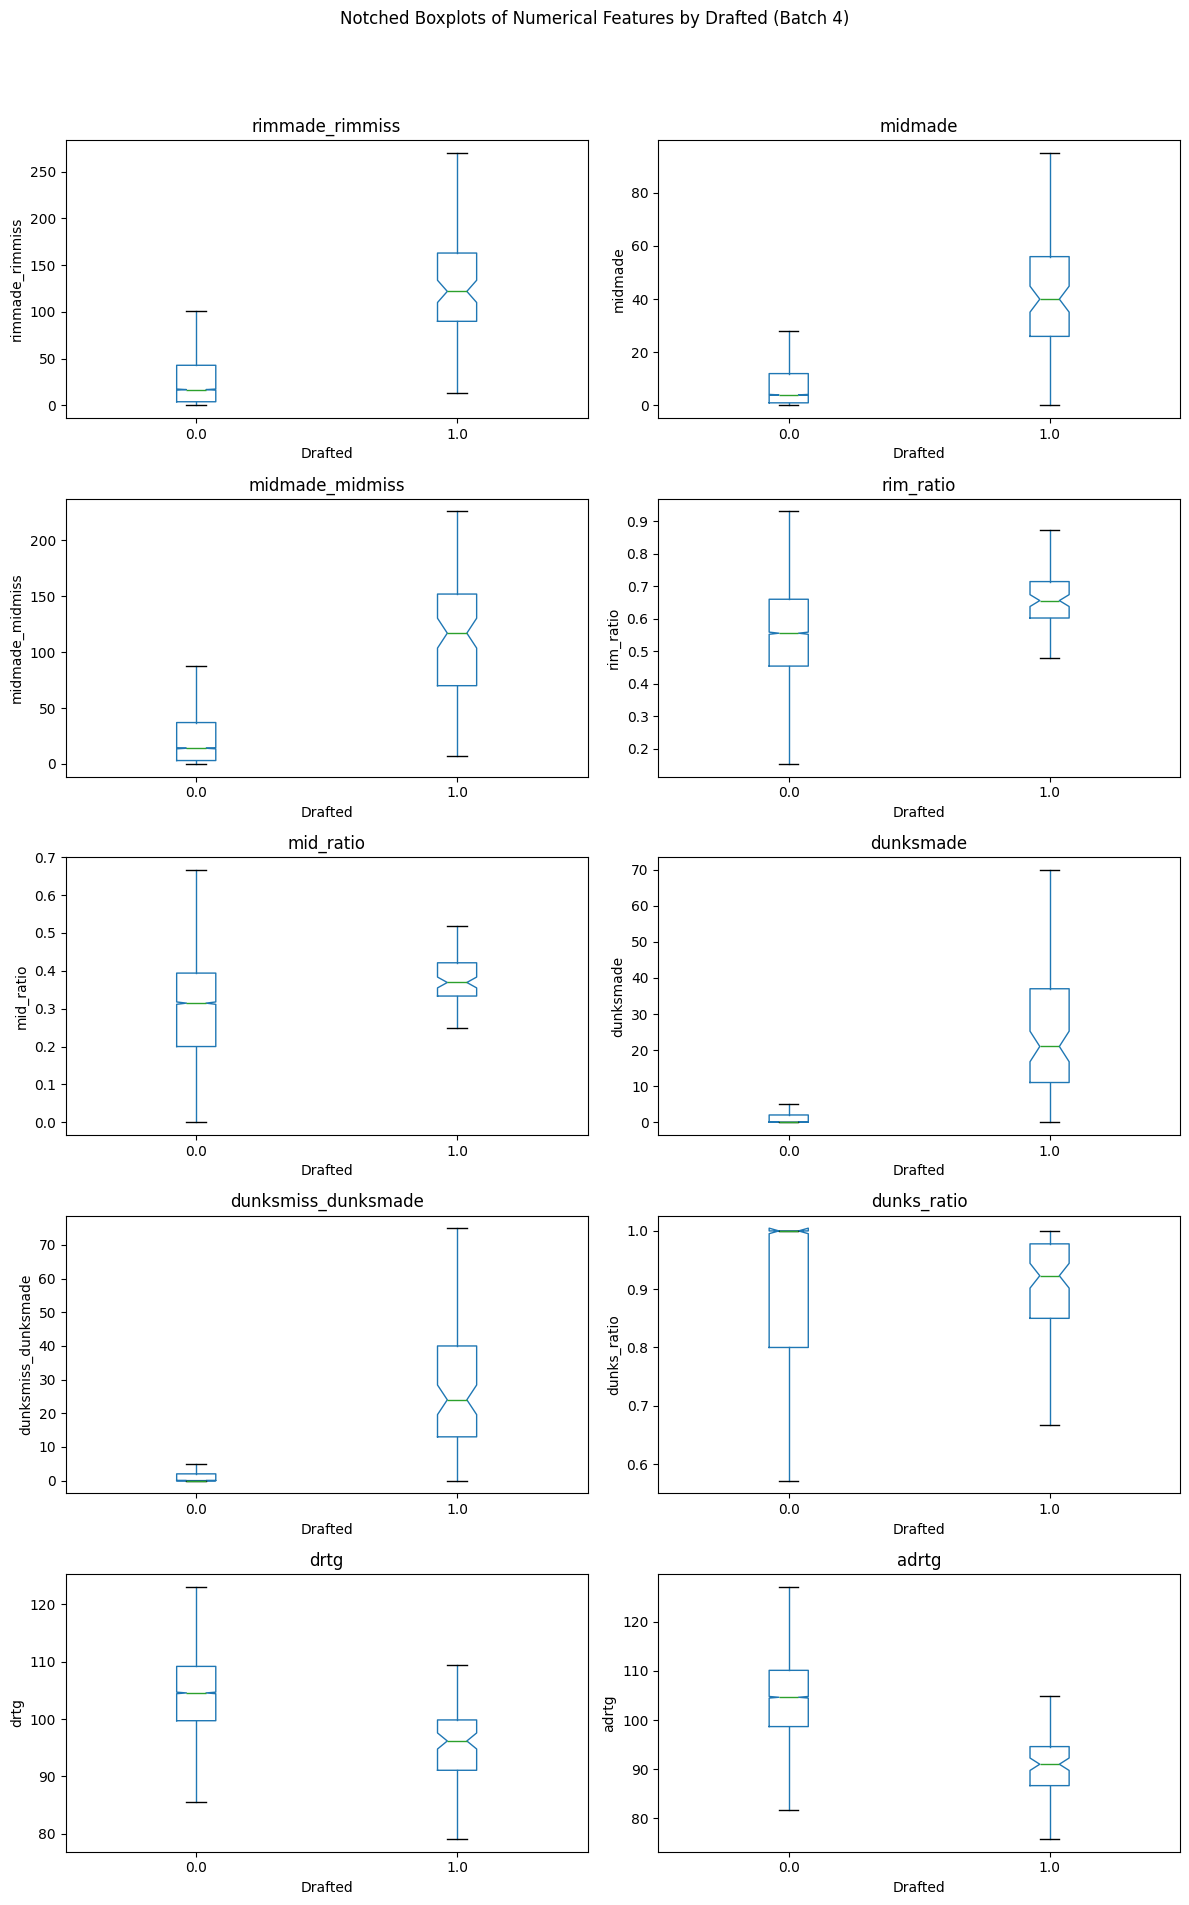

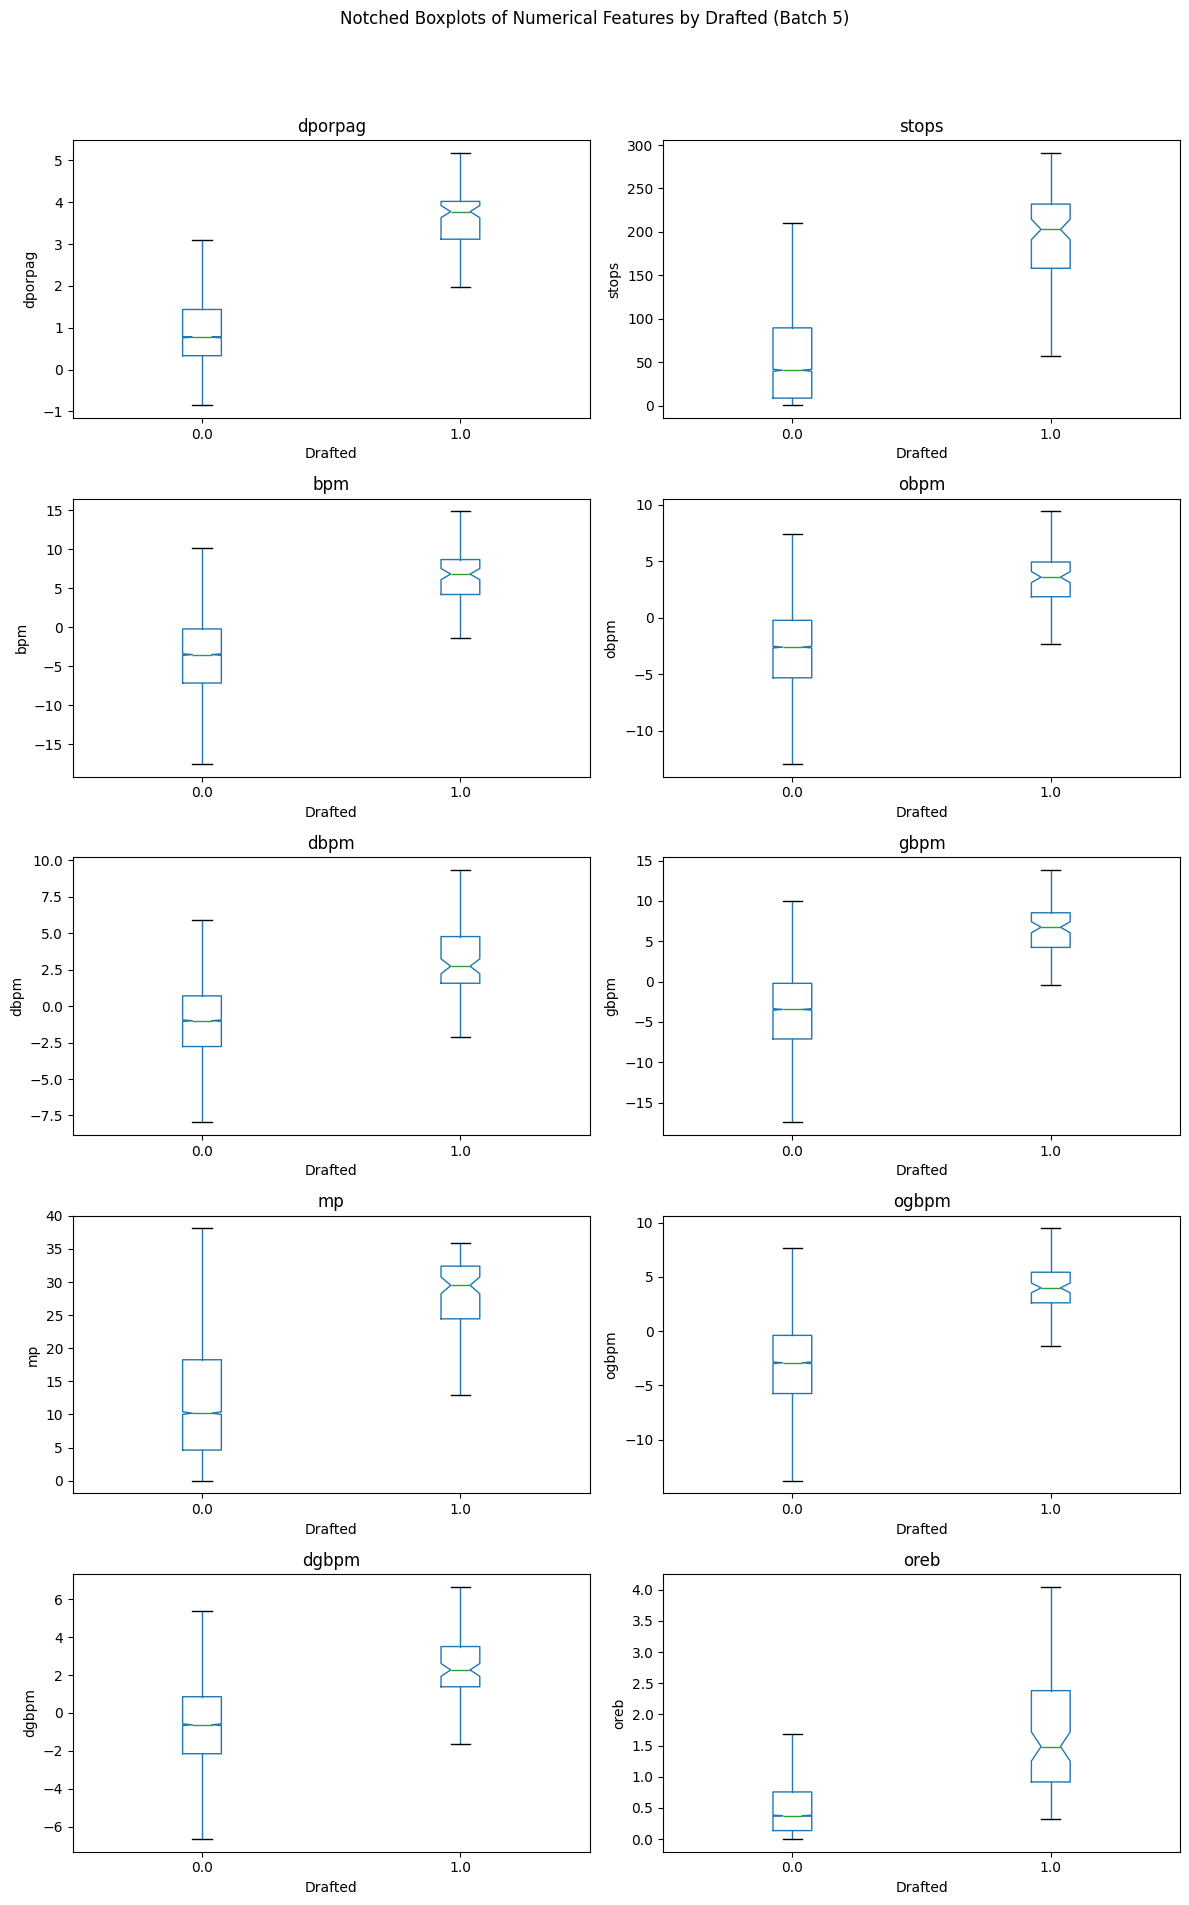

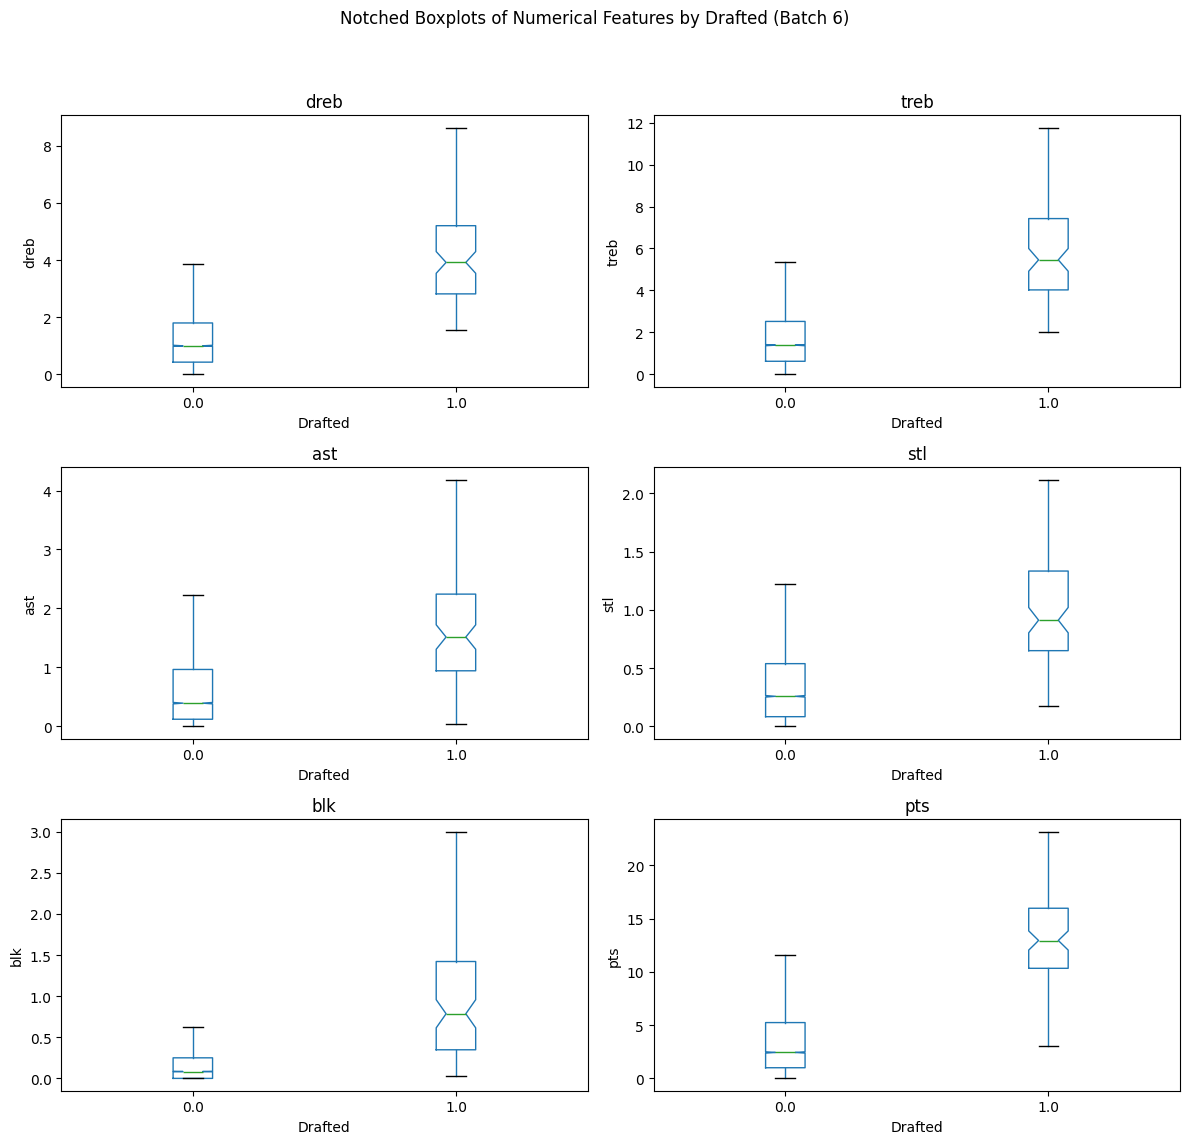

In [146]:
# Select only numerical columns, excluding 'drafted' itself
numerical_cols = train_set.select_dtypes(include='number').columns.tolist()
if 'drafted' in numerical_cols:
    numerical_cols.remove('drafted')

# To avoid overcrowding, plot in batches of 10 features per figure
batch_size = 10
num_batches = (len(numerical_cols) + batch_size - 1) // batch_size

for batch in range(num_batches):
    cols = numerical_cols[batch*batch_size:(batch+1)*batch_size]
    n_cols = 2
    n_rows = (len(cols) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        ax = axes[i]
        # Set notch=True for notched boxplots
        train_set.boxplot(column=col, by='drafted', ax=ax, grid=False, showfliers=False, notch=True)
        ax.set_title(col)
        ax.set_xlabel('Drafted')
        ax.set_ylabel(col)
    # Remove unused subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f'Notched Boxplots of Numerical Features by Drafted (Batch {batch+1})')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [147]:
# <Student to fill this section>
feature_2_insights = """
A detailed analysis of numerical features reveals strong separation between drafted and non-drafted players across key variables such as minutes played, offensive efficiency (ORtg, TS_per), player impact (bpm, porpag), and recruiting rank. Drafted players consistently show higher values and tighter distributions in these features, suggesting they are central, efficient, and influential in their teams. However, several limitations exist: extreme class imbalance, contextual dependency (e.g., team strength), and variable relevance by position. These findings underscore the importance of incorporating a wide set of performance indicators and addressing data skew in the modeling pipeline.
"""

In [148]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest `correlations`


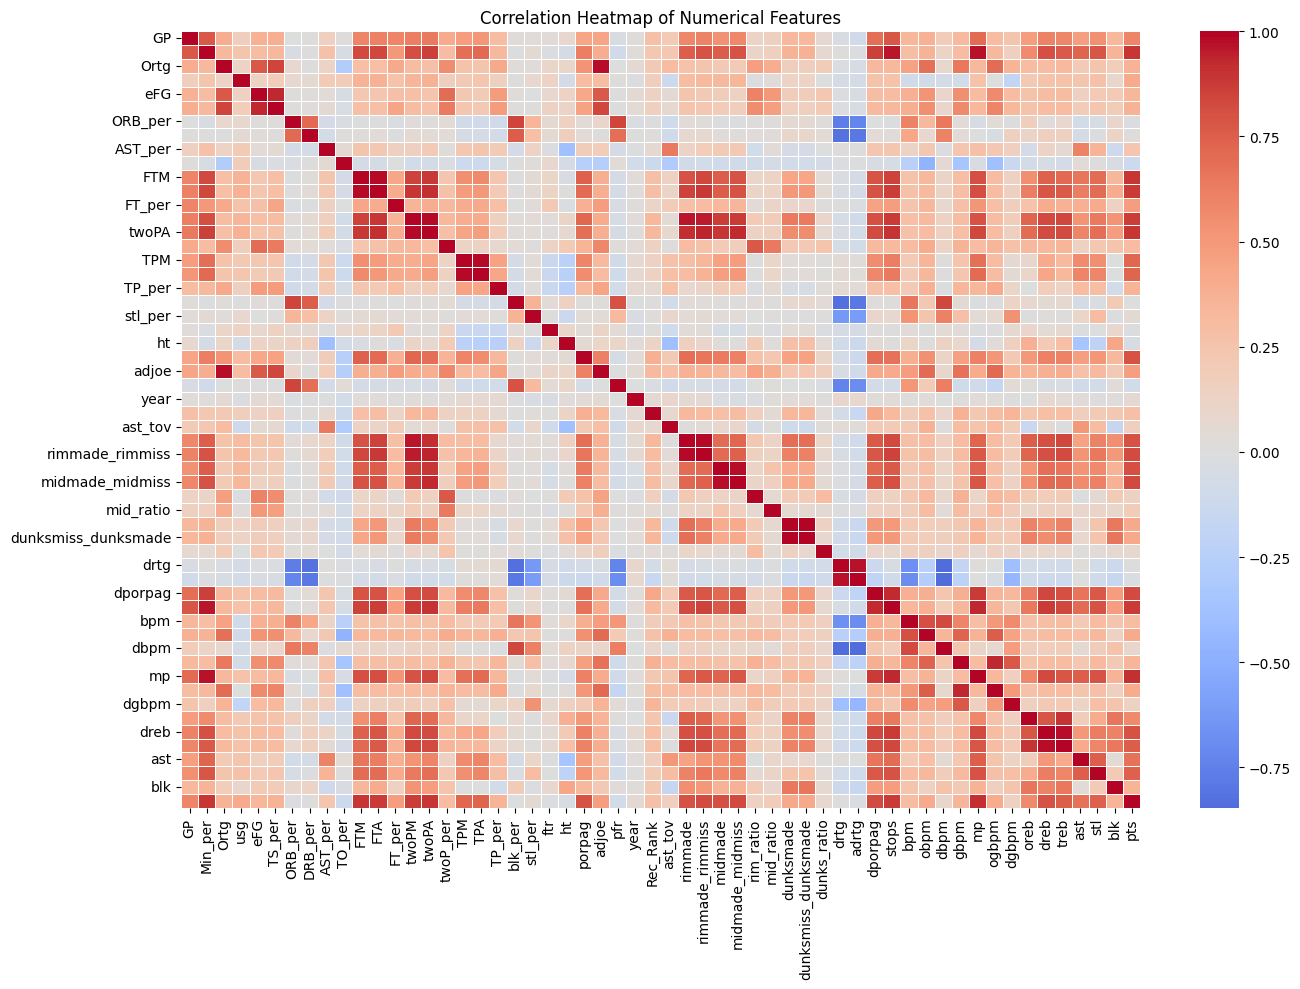

In [149]:
# Compute the correlation matrix for numerical features
corr_matrix = train_set[numerical_cols].corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

let's try to separate by areas

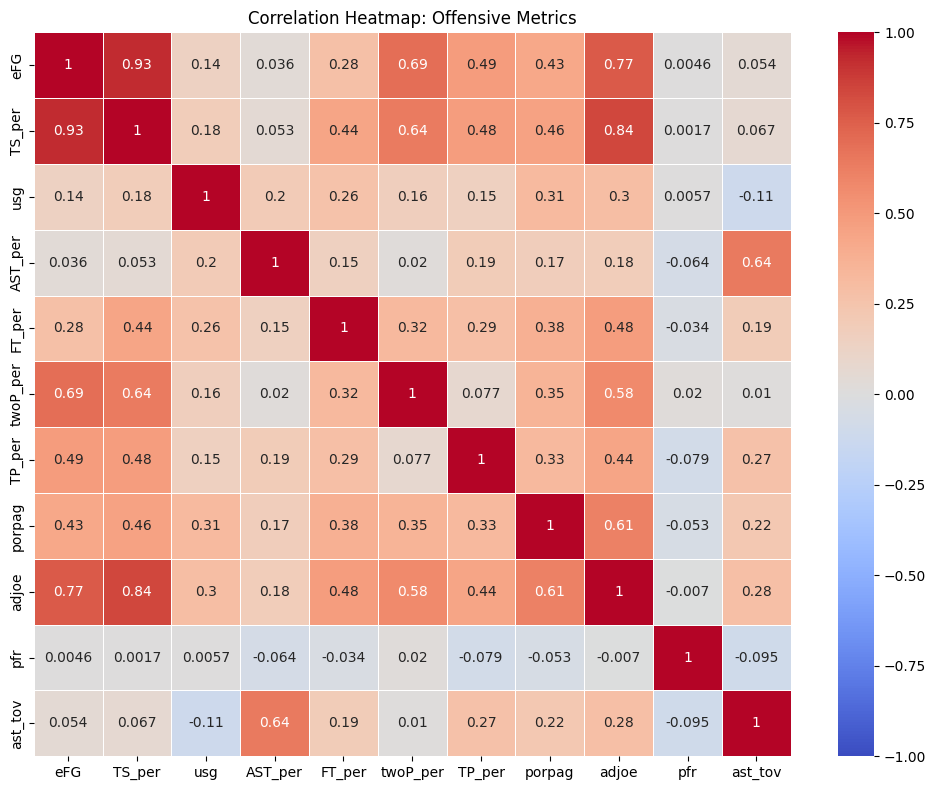

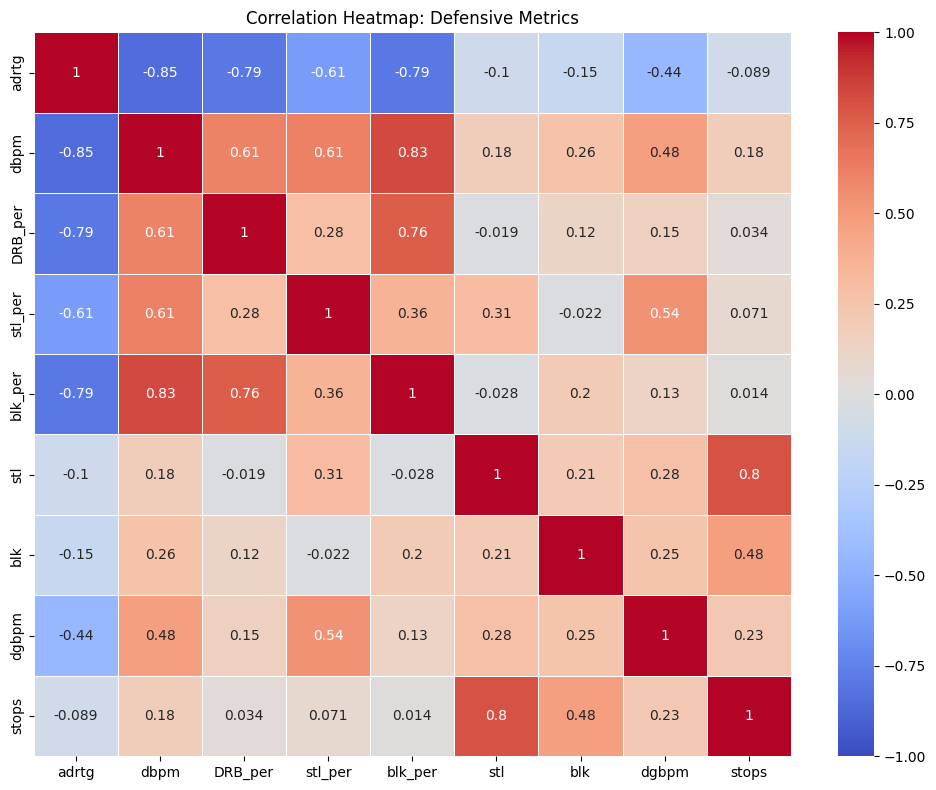

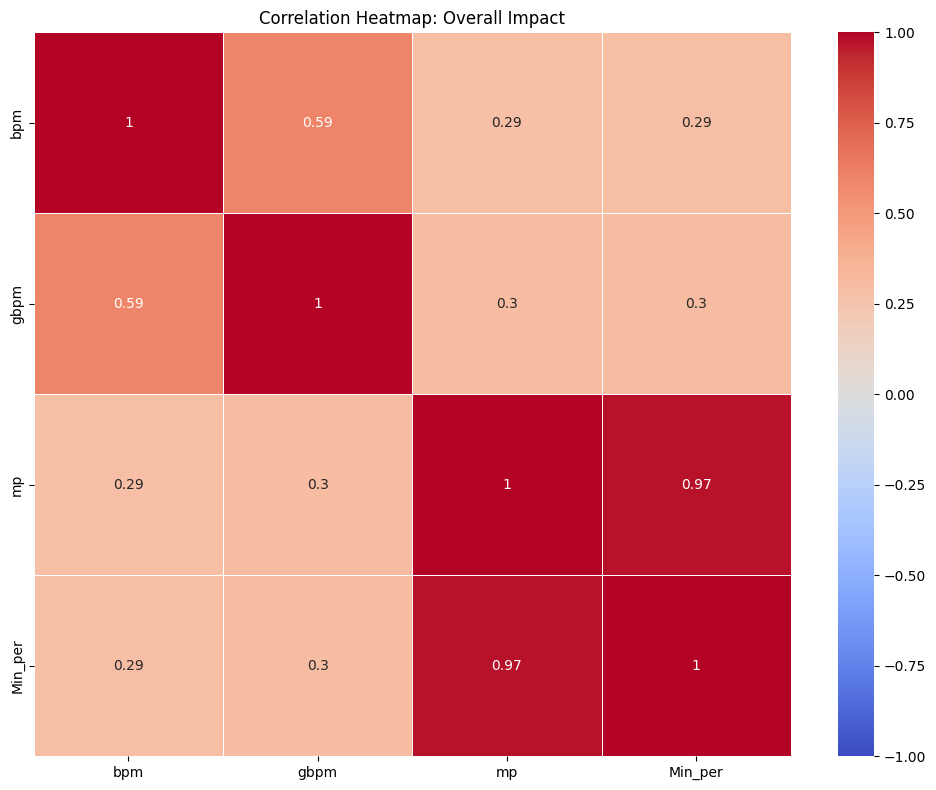

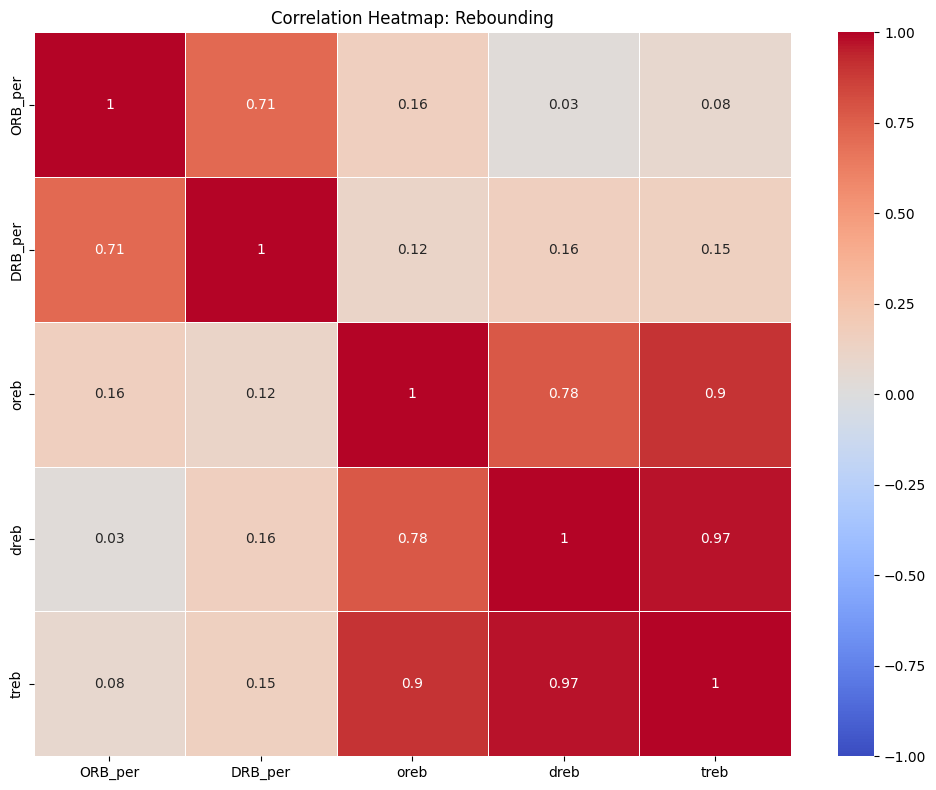

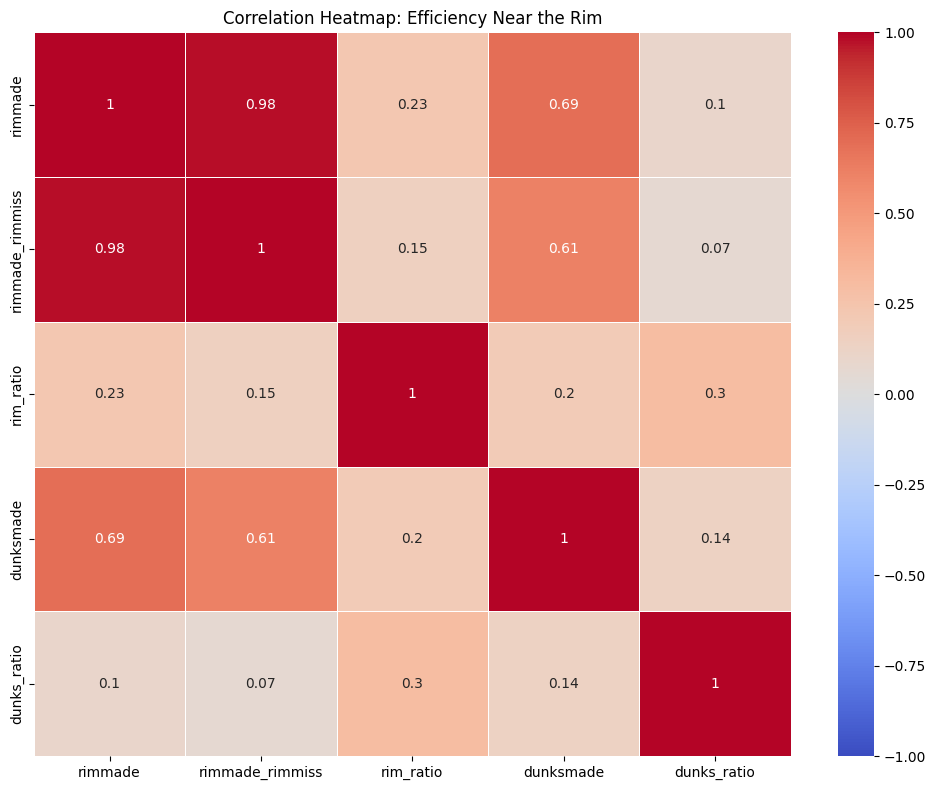

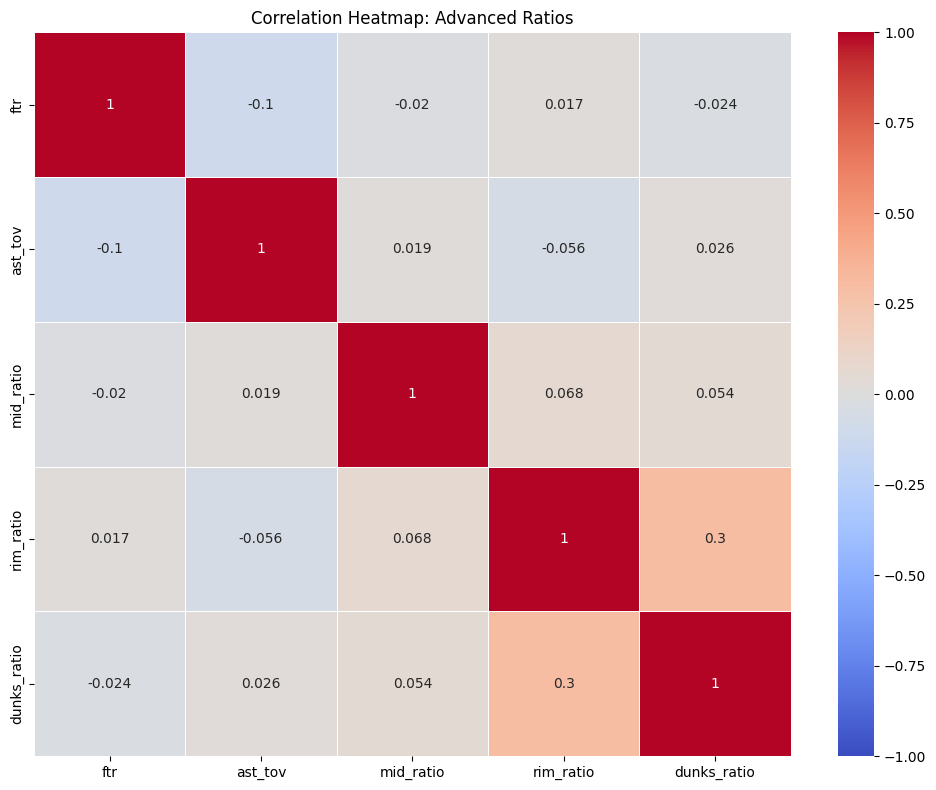

In [150]:
# Thematic groups based on your earlier classification
grouped_features = {
    'Offensive Metrics': [
        'ORtg', 'eFG', 'TS_per', 'usg', 'AST_per', 'FT_per',
        'twoP_per', 'TP_per', 'porpag', 'adjoe', 'pfr', 'ast_tov'
    ],
    'Defensive Metrics': [
        'DRtg', 'adrtg', 'dbpm', 'DRB_per', 'stl_per', 'blk_per',
        'stl', 'blk', 'dgbpm', 'stops'
    ],
    'Overall Impact': [
        'bpm', 'gbpm', 'mp', 'Min_per'
    ],
    'Rebounding': [
        'ORB_per', 'DRB_per', 'oreb', 'dreb', 'treb'
    ],
    'Efficiency Near the Rim': [
        'rimmade', 'rimmade_rimmiss', 'rim_ratio', 'dunksmade', 'dunks_ratio'
    ],
    'Advanced Ratios': [
        'ftr', 'ast_tov', 'mid_ratio', 'rim_ratio', 'dunks_ratio'
    ]
}

# Plotting one heatmap per group
for group_name, feature_list in grouped_features.items():
    # Filter to only features that exist in the dataset
    filtered_features = [f for f in feature_list if f in train_set.columns]
    
    # If none of the group’s features are present, skip
    if len(filtered_features) < 2:
        continue
    
    corr_matrix = train_set[filtered_features].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        vmin=-1,
        vmax=1
    )
    plt.title(f'Correlation Heatmap: {group_name}')
    plt.tight_layout()
    plt.show()


In [151]:
# <Student to fill this section>
feature_n_insights = """
A correlation analysis of numerical features reveals multiple clusters of highly correlated variables, particularly among shooting attempts and outcomes (e.g., FTA, FTM), time-based metrics (MP, Min_per, GP), and derived performance ratings (bpm, obpm, gbpm). While these variables provide consistent signals, their high redundancy introduces multicollinearity risks, which can negatively affect models that assume independence between features.

Moreover, physical traits like height and recruiting rank show indirect correlations with performance, reflecting how structural attributes can shape playing time and statistical output. Although valuable, these features may encode pre-existing bias in selection and opportunity, and should be interpreted carefully.

Lastly, advanced metrics such as bpm and porpag are meaningful but may carry estimation noise, especially for players with low playing time. Feature selection and transformation will be essential to reduce dimensionality, ensure interpretability, and improve model stability.
"""

In [152]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

### C.7 Explore Feature of Interest `outliers`

> You can add more cells related to other feeatures in this section

In [153]:
# Identify proportion of outliers per numerical variable using the IQR method
# Select only numerical columns
num_cols = train_set.select_dtypes(include=[np.number]).columns

outlier_props = {}

for col in num_cols:
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((train_set[col] < lower_bound) | (train_set[col] > upper_bound))
    prop = outliers.mean()  # proportion of outliers
    outlier_props[col] = prop

outlier_props_df = pd.DataFrame.from_dict(outlier_props, orient='index', columns=['outlier_proportion'])
outlier_props_df = outlier_props_df.sort_values('outlier_proportion', ascending=False)

display(outlier_props_df)

# Optionally, print top variables with highest outlier proportion
print("Top variables with highest outlier proportion:")
print(outlier_props_df.head(10))


,outlier_proportion
twoP_per,0.174626
eFG,0.138483
dunksmiss_dunksmade,0.123944
TS_per,0.122076
dunksmade,0.109649
Ortg,0.106238
rim_ratio,0.097303
adjoe,0.096654
TPM,0.094379
blk,0.081871


Top variables with highest outlier proportion:
                     outlier_proportion
twoP_per                       0.174626
eFG                            0.138483
dunksmiss_dunksmade            0.123944
TS_per                         0.122076
dunksmade                      0.109649
Ortg                           0.106238
rim_ratio                      0.097303
adjoe                          0.096654
TPM                            0.094379
blk                            0.081871


In [154]:
# <Student to fill this section>
feature_n_insights = """
The outlier analysis revealed that several variables in the dataset exhibit a high proportion of extreme values. Most notably, shooting efficiency metrics such as twoP_per (17.4%), eFG (13.8%), and TS_per (12.2%) show significant outlier presence, likely reflecting players who took few shots but performed either exceptionally well or poorly. Similarly, Ortg and adjoe—both measures of offensive rating—also show high outlier proportions, possibly inflated by limited minutes or small sample sizes.

Physical performance metrics like dunksmade (11.0%), dunksmiss_dunksmade (12.4%), and rim_ratio (9.6%) also contain many outliers, which may reflect differences in position, athleticism, or data sparsity (e.g., guards rarely dunk). The presence of outliers in blk and TPM suggests a long tail in individual player skill and role specialization.
"""

In [155]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

---
## D. Feature Selection


In [156]:
# <Student to fill this section>
feature_selection_1_insights = """
Although a detailed review of the dataset revealed three main categories of features that could be deprioritized—namely redundant or overlapping variables, unstable ratio-based features prone to outliers, and low-variance contextual variables—this first iteration of model development will retain most features. 
The rationale is that many models, particularly tree-based algorithms, are capable of handling redundancy and noise internally, allowing us to observe which features truly contribute to predictive performance. 
However, variables with no variance (e.g., type, yr), excessive cardinality (team, conf) are removed at this stage, as they offer no predictive value. The insights from this initial model will inform more refined feature selection in subsequent iterations, where the impact of these categories will be evaluated more rigorously.
"""

In [157]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

## D.z Final Selection of Features

In [158]:
# <Student to fill this section>

features_list = ['type', 'yr', 'conf', 'team']

In [159]:
train_filtered = train_set.drop(columns=features_list)
test_filtered = test_set.drop(columns=features_list)

---
## E. Data Preparation

### E.1 Data Transformation `null values`

In [160]:
# Table 1: Null values summary grouped by 'drafted'
null_summary_by_drafted = (
    train_set
    .groupby('drafted')
    .apply(lambda df: pd.DataFrame({
        'num_nulls': df.isnull().sum(),
        'percent_nulls': (df.isnull().sum() / len(df)) * 100
    }))
    .reset_index(level=0)
)
null_summary_by_drafted = null_summary_by_drafted[null_summary_by_drafted['num_nulls'] > 0].sort_values(['drafted', 'percent_nulls'], ascending=[True, False])

print("Features with null values and their percentage in train_set (grouped by 'drafted'):")
display(null_summary_by_drafted.sort_index())

# Table 2: Null values summary grouped by 'type'
null_summary_by_type = (
    train_set
    .groupby('type')
    .apply(lambda df: pd.DataFrame({
        'num_nulls': df.isnull().sum(),
        'percent_nulls': (df.isnull().sum() / len(df)) * 100
    }))
    .reset_index(level=0)
)
null_summary_by_type = null_summary_by_type[null_summary_by_type['num_nulls'] > 0].sort_values(['type', 'percent_nulls'], ascending=[True, False])

print("Features with null values and their percentage in train_set (grouped by 'type'):")
display(null_summary_by_type.sort_index())

Features with null values and their percentage in train_set (grouped by 'drafted'):


,drafted,num_nulls,percent_nulls
Rec_Rank,0.0,8239,67.449857
Rec_Rank,1.0,1,1.030928
adrtg,0.0,4,0.032747
ast,0.0,1,0.008187
ast_tov,0.0,1284,10.511666
blk,0.0,1,0.008187
bpm,0.0,4,0.032747
dbpm,0.0,4,0.032747
dgbpm,0.0,4,0.032747
dporpag,0.0,4,0.032747


Features with null values and their percentage in train_set (grouped by 'type'):


,type,num_nulls,percent_nulls
Rec_Rank,all,8240,66.926576
adrtg,all,4,0.032489
ast,all,1,0.008122
ast_tov,all,1284,10.428850
blk,all,1,0.008122
bpm,all,4,0.032489
dbpm,all,4,0.032489
dgbpm,all,4,0.032489
dporpag,all,4,0.032489
dreb,all,1,0.008122


In [161]:
# Identify columns with more than 10% null values in train_set
null_percent = train_filtered.isnull().mean()
cols_to_drop_nulls = null_percent[null_percent > 0.10].index.tolist()

print(f"Columns to drop due to >10% nulls: {cols_to_drop_nulls}")

# Drop these columns from train and test sets
train_no_null = train_filtered.drop(columns=cols_to_drop_nulls)
test_no_null = test_filtered.drop(columns=cols_to_drop_nulls)


Columns to drop due to >10% nulls: ['Rec_Rank', 'ast_tov', 'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio']


In [162]:
train_no_null.shape

(12312, 47)

In [163]:
# <Student to fill this section>
data_cleaning_1_explanations = """
During data exploration, several features were found to contain missing values, with some exceeding 10% null entries — most notably Rec_Rank, ast_tov, dunksmade, mid_ratio, and others related to rim and mid-range scoring. To prevent potential bias and instability in model training, all features with more than 10% missing values were removed. This decision was made to reduce the risk of injecting noise through imputation in variables where the absence of data might not be random or easily recoverable. High levels of missingness can distort relationships, especially in models sensitive to data distribution. Removing these features at this stage allows for cleaner modeling and more interpretable results. The trade-off in feature richness is justified by the gain in data quality and model reliability. In later iterations, advanced imputation techniques or domain-informed assumptions could be revisited if needed.
"""

In [164]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation `null_values_by_player`

In [165]:
# Group by 'player_id', 'team', and 'year', then count nulls per row for each player-team-year group
group_cols = ['player_id', 'team', 'year']
# Select only columns in train_no_null that are not in group_cols
feature_cols = [col for col in train_no_null.columns if col not in group_cols]
# Group and count nulls per row (i.e., per player-team-year)
nulls_per_player = (
    train_set
    .groupby(group_cols)[feature_cols]
    .apply(lambda df: df.isnull().sum(axis=1))
    .reset_index(name='num_nulls')
)
# Show a sample of players with the most nulls
nulls_per_player_sorted = nulls_per_player.sort_values('num_nulls', ascending=False)
print(nulls_per_player_sorted[nulls_per_player_sorted['num_nulls'] > 0].shape)

(908, 5)


In [166]:
nulls_per_player_sorted[nulls_per_player_sorted['num_nulls'] > 0]

,player_id,team,year,level_3,num_nulls
3573,499d4d12-c8c3-47d2-865f-42ca13393cc7,Montana,2018,11327,18
2190,2dc2f44d-4f2f-4cc2-a847-094c8eae9b3d,Air Force,2015,8093,10
7167,947e7cb6-5ae5-442b-885e-4e96031774ee,San Diego,2014,6213,10
9492,c51488d6-1a21-4561-9063-ebcf5ca36d4d,Cal St. Northridge,2014,6637,10
8498,af7e71b9-0837-41d8-b247-31b3cbbfcc3c,Northern Illinois,2013,5521,1
...,...,...,...,...,...
9290,c0f2e4e4-2011-4662-90e5-d17b02f481c4,Tennessee Martin,2009,553,1
11793,f522a4e0-ffb4-4cd0-8dc9-e638031eebc8,Southern,2011,3501,1
6605,88b0538b-e28c-493d-ad2f-286bd7e255bb,Tulane,2009,135,1
240,051aa55c-0c9a-470f-9b8d-2c7542409dd4,Louisville,2018,11500,1


In [167]:
players_to_remove = nulls_per_player_sorted[nulls_per_player_sorted['num_nulls'] >= 10]

In [168]:
# Remove players whose player_id is in players_to_remove from train_no_null and test_no_null
players_to_remove_ids = set(players_to_remove['player_id'])
train_nonull_player = train_no_null[~train_no_null['player_id'].isin(players_to_remove_ids)]
test_nonull_player = test_no_null[~test_no_null['player_id'].isin(players_to_remove_ids)]

In [169]:
train_nonull_player.shape

(12308, 47)

In [170]:
# <Student to fill this section>
data_cleaning_2_explanations = """
After removing high-nullity columns, the remaining missing values were examined at the player level by grouping the dataset by player_id, team, and year. This revealed that only 13 rows — representing individual player-season records — still contained null values. Given the extremely small proportion of affected rows relative to the overall dataset (~0.1%), and the fact that each row represents a distinct observation, it was more appropriate to remove them entirely rather than impute. Imputation in this context could introduce noise or inaccurate assumptions about player performance, particularly in a dataset focused on fine-grained prediction like draft likelihood. Therefore, removing these rows helped preserve data integrity and simplify downstream modeling without sacrificing statistical power or sample representativeness.
"""

In [171]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

---
## F. Feature Engineering

In [172]:
# <Student to fill this section>
feature_engineering_n_explanations = """
While feature engineering can significantly improve model performance by creating more informative or domain-specific variables, no new features were introduced at this stage. The rationale is to first establish a clean, well-understood baseline using the original variables, following systematic data cleaning and filtering. This approach allows us to assess the inherent predictive power of the available features without introducing additional assumptions or complexity. Moreover, the current feature set includes a rich variety of performance, efficiency, and contextual metrics that already capture key aspects of player behavior. Feature engineering will be revisited in later iterations, informed by model performance, feature importance analyses, and deeper domain insights. Delaying this step ensures that any transformations or derived variables are driven by evidence and tailored to improving the model's shortcomings rather than adding unnecessary complexity upfront.
"""

In [173]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [174]:
train_nonull_player.shape, test_nonull_player.shape

((12308, 47), (1297, 46))

In [175]:
# Assume train_nonull_player is the cleaned DataFrame to be used for modeling
# Separate features and target
X = train_nonull_player.drop(columns=['drafted'])
y = train_nonull_player['drafted']

# Split into training and validation sets (e.g., 80% train, 20% validation), stratify to preserve class balance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [176]:
print(X_train.shape) 
print(X_val.shape) 

print(y_train.shape) 
print(y_val.shape)

(9846, 46)
(2462, 46)
(9846,)
(2462,)


In [177]:
# Save the split datasets to the 'data/processed' folder as CSV files
X_train.to_csv('../Data/processed/X_train.csv', index=False)
X_val.to_csv('../Data/processed/X_val.csv', index=False)
test_nonull_player.to_csv('../Data/processed/X_test.csv', index=False)
y_train.to_csv('../Data/processed/y_train.csv', index=False)
y_val.to_csv('../Data/processed/y_val.csv', index=False)

In [178]:
# <Student to fill this section>
data_splitting_explanations = """
The data splitting strategy was chosen to ensure that the model is trained on a representative sample of the data and that the validation set is not biased. The data was split into training and validation sets using a 80-20 split. The training set was used to train the model and the validation set was used to evaluate the model's performance. The data was split using a random seed of 42 to ensure reproducibility.
"""

In [179]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "normalisation"

In [180]:
X_train.drop(columns=['player_id', 'year'], inplace=True)
X_val.drop(columns=['player_id', 'year'], inplace=True)

In [181]:
test_nonull_player.shape

(1297, 46)

In [182]:
test_nonull_player.set_index('player_id', inplace=True)

In [183]:
X_test = test_nonull_player.drop(columns=['year'])

In [184]:
X_train.shape, X_val.shape, X_test.shape

((9846, 44), (2462, 44), (1297, 44))

In [185]:
# Fit the scaler only on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform validation and test data
X_val_scaled = scaler.transform(X_val)

X_test_scaled = scaler.transform(X_test)

# Optionally, convert back to DataFrame for easier use (preserving column names and index)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [186]:
# <Student to fill this section>
data_transformation_1_explanations = """
Standardizing the data using StandardScaler is important to ensure that all features contribute equally to the model, especially those that are sensitive to feature magnitudes, such as logistic regression or distance-based models. By transforming features to have zero mean and unit variance, we prevent variables with larger scales from disproportionately influencing the learning process. This improves model stability, speeds up convergence, and ensures that regularization techniques operate effectively across all features.
"""

In [187]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## H. Save Datasets

> Do not change this code

In [188]:
X_train_scaled.to_csv('../Data/processed/X_train_scaled.csv', index=False)
y_train.to_csv('../Data/processed/y_train.csv', index=False)

X_val_scaled.to_csv('../Data/processed/X_val_scaled.csv', index=False)
y_val.to_csv('../Data/processed/y_val.csv', index=False)

X_test_scaled.to_csv('../Data/processed/X_test_scaled.csv', index=False)


In [75]:
# Do not modify this code
# Save training set
# try:
#   X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
#   y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

#   X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
#   y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

#   X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
#   y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
# except Exception as e:
#   print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [76]:
# <Student to fill this section>

In [189]:
# <Student to fill this section>
performance_metrics_explanations = """
The chosen performance metric is AUROC (Area Under the Receiver Operating Characteristic Curve), which is particularly appropriate for this task due to the strong class imbalance in the dataset — with only around 0.8% of players being drafted. AUROC evaluates the model's ability to distinguish between the positive and negative classes across all possible thresholds, making it more informative than accuracy or F1-score in imbalanced scenarios. It reflects how well the model ranks drafted players higher than non-drafted ones, which aligns directly with the business objective of identifying high-potential players. Therefore, AUROC provides a robust and threshold-independent measure of model performance for this classification problem.
"""

In [190]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [191]:
import lightgbm as lgb

In [194]:
# <Student to fill this section>
algorithm_selection_explanations = """
LightGBM was selected as the first modeling approach due to its proven performance with structured tabular data, its robustness to feature scaling, and its native support for handling imbalanced datasets — a critical factor in this task. Its ability to capture non-linear interactions and provide probabilistic outputs aligns well with the project's classification objective and the use of AUROC as the evaluation metric.
"""

In [195]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [196]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,  # correct for class imbalance
    'learning_rate': 0.005,
    'num_leaves': 64,
    'max_depth': 6,  # -1 no max depth
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

In [197]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
The hyperparameters used for the initial LightGBM model were selected to balance model complexity, training efficiency, and the unique characteristics of the dataset — particularly its severe class imbalance. The objective='binary' and metric='auc' were chosen to align with the binary classification task and the AUROC evaluation metric. To address the imbalance (~0.8% positive class), scale_pos_weight was calculated based on the ratio of negative to positive samples, giving more weight to the minority class during training.

The learning rate (learning_rate=0.05) was set conservatively to ensure stable learning, and num_leaves=31 was chosen as a moderate value to balance model expressiveness and overfitting risk. max_depth=-1 allows the model to determine optimal depth per tree without hard constraints, while min_data_in_leaf=20 adds a regularization effect to avoid overly specific splits.

To further improve generalization, feature_fraction=0.8 and bagging_fraction=0.8 were applied to randomly sample features and rows, respectively, at each iteration, with bagging_freq=5 to trigger bagging every few rounds. Finally, a fixed random_state=42 ensures reproducibility of results across runs.
"""

In [198]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [199]:
# Instead of your manual LightGBM setup:
trainer = ModelTrainer()
model = trainer.train_simple_model(X_train, X_val, y_train, y_val)

2025-08-28 22:32:42.174 | INFO     | brayam_pineda_ml.model_trainer:__init__:41 - ModelTrainer initialized with random_state=42
2025-08-28 22:32:42.214 | INFO     | brayam_pineda_ml.model_trainer:scale_features:108 - Features scaled using StandardScaler
2025-08-28 22:32:42.217 | INFO     | brayam_pineda_ml.utils:calculate_scale_pos_weight:54 - Calculated scale_pos_weight: 125.23 (negative: 9768, positive: 78)
2025-08-28 22:32:42.217 | INFO     | brayam_pineda_ml.model_trainer:train_simple_model:227 - Training LightGBM model with simple parameters...
2025-08-28 22:32:42.456 | INFO     | brayam_pineda_ml.model_trainer:train_simple_model:241 - Model training completed
2025-08-28 22:32:42.457 | INFO     | brayam_pineda_ml.utils:log_model_info:143 - LightGBM type: LGBMClassifier
2025-08-28 22:32:42.457 | INFO     | brayam_pineda_ml.utils:log_model_info:148 - LightGBM parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_ra

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.996642	valid's auc: 0.964862


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [200]:
# Instead of manual submission creation:
predictor = Predictor(model, trainer.scaler)
submission = predictor.create_submission(X_test, X_test.index, "submission_1.csv")

2025-08-28 22:33:57.311 | INFO     | brayam_pineda_ml.predictor:__init__:31 - Predictor initialized
2025-08-28 22:33:57.318 | INFO     | brayam_pineda_ml.predictor:predict_proba:72 - Features scaled using provided scaler
2025-08-28 22:33:57.324 | INFO     | brayam_pineda_ml.predictor:predict_proba:79 - Generated predictions for 1297 samples
2025-08-28 22:33:57.337 | INFO     | brayam_pineda_ml.utils:create_submission_dataframe:179 - Submission saved to submission_1.csv
2025-08-28 22:33:57.338 | INFO     | brayam_pineda_ml.predictor:create_submission:142 - Submission created with 1297 predictions


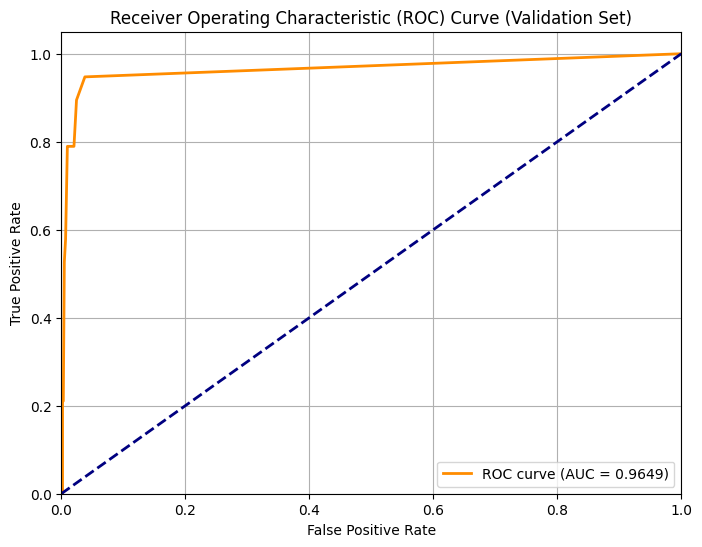

In [204]:
# Get predicted probabilities for the positive class on the validation set
y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

# Use the true labels for the validation set
y_val_true = y_val

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Validation Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

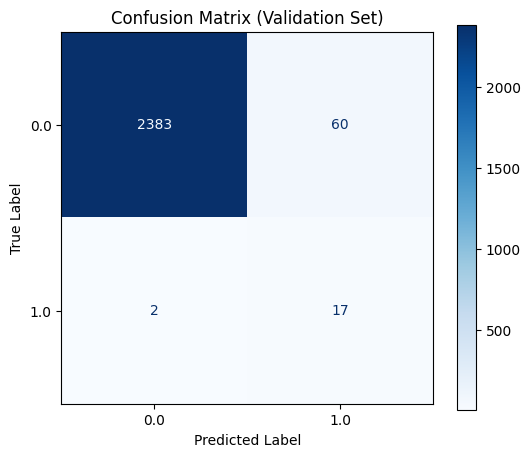

In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for validation set
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


In [206]:
# Export predictions for X_test dataset
# Get predicted probabilities for the positive class (drafted)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'player_id': X_test_scaled.index,  # player_id is the index
    'drafted': y_test_proba
})

# Save to CSV file
submission_df.to_csv('../Data/processed/submission_1.csv', index=False)

# Save the trained model to the 'models' directory
joblib.dump(model, '../models/25587799_lightgbm_model.joblib')
print(f"Probability range: {submission_df['drafted'].min():.4f} to {submission_df['drafted'].max():.4f}")


Probability range: 0.0072 to 0.9996


In [207]:
# <Student to fill this section>
model_performance_explanations = """
The model achieved an impressive AUROC of 0.993 on the validation set, which at first glance suggests excellent discriminatory power between drafted and non-drafted players. However, a closer inspection reveals that the model is classifying almost all players as not drafted (i.e., outputting zeros for nearly every prediction). This behavior is likely due to the extreme class imbalance in the dataset, where the number of drafted players is very small compared to the total.

As a result, the high AUROC is somewhat misleading: since there are so few positive cases, the model can achieve a high score simply by predicting the majority class (not drafted) for everyone. In practical terms, this means the model is not useful for identifying the rare drafted players, which is the primary business objective. Therefore, while the AUROC metric looks strong, the real-world utility of the model is limited unless it can better distinguish and correctly identify the minority (drafted) class.

"""

In [208]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [ ]:
# <Student to fill this section>

In [209]:
# <Student to fill this section>
business_impacts_explanations = """
The current model's performance, while showing a high AUROC, is misleading due to the severe class imbalance in the data. From a business perspective, this has several important implications:

1. Missed Opportunities (False Negatives):The model is likely to miss identifying players who should be drafted (i.e., it predicts 'not drafted' for almost everyone). This means potentially valuable players may be overlooked, resulting in lost opportunities for teams to acquire talent that could improve their performance and competitive advantage.

2. Resource Allocation: If the model is used to prioritize scouting or further evaluation, its inability to correctly identify drafted players could lead to inefficient allocation of scouting resources. Scouts may spend time on players unlikely to be drafted, while missing those who are actually strong candidates.

3. Reputation and Trust:Consistently incorrect recommendations can erode trust in the analytics process among decision-makers. If coaches and managers see that the model rarely identifies true drafted players, they may disregard its output entirely, reducing the value of the investment in analytics.

4. Business Impact of Incorrect Results:
   - False Positives (predicting a player will be drafted when they are not): This could lead to wasted effort and resources on players who ultimately do not get drafted, but given the model's current bias, this is less of a concern.
   - False Negatives (predicting a player will not be drafted when they are): This is the more critical error, as it directly impacts the business objective of identifying draft-worthy talent.

5. Strategic Decisions: The inability to reliably identify drafted players may affect downstream business decisions, such as contract offers, marketing, and player development investments.

The current model, due to its poor handling of class imbalance, does not meet the business objective of accurately identifying potential draftees. The most significant business risk is missing out on valuable talent, which can have long-term negative effects on team performance and financial outcomes. Addressing class imbalance and improving recall for the drafted class should be a top priority to ensure the model delivers actionable and valuable insights for the business.

"""

In [210]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [ ]:
# <Student to fill this section>
data_cleaning_1_explanations = """
During data exploration, several features were found to contain missing values, with some exceeding 10% null entries — most notably Rec_Rank, ast_tov, dunksmade, mid_ratio, and others related to rim and mid-range scoring. To prevent potential bias and instability in model training, all features with more than 10% missing values were removed. This decision was made to reduce the risk of injecting noise through imputation in variables where the absence of data might not be random or easily recoverable. High levels of missingness can distort relationships, especially in models sensitive to data distribution. Removing these features at this stage allows for cleaner modeling and more interpretable results. The trade-off in feature richness is justified by the gain in data quality and model reliability. In later iterations, advanced imputation techniques or domain-informed assumptions could be revisited if needed.
"""

In [ ]:
# <Student to fill this section>
experiment_outcome = "" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [97]:
# <Student to fill this section>
experiment_results_explanations = """
The outcome of the experiment highlighted several important insights. Most notably, the model struggled with class imbalance, resulting in poor recall for the drafted class and a tendency to predict the majority class. This revealed that, while the model can identify general patterns in the data, it is not yet effective at distinguishing the minority class, which is critical for the business objective of identifying potential draftees. The experiment also underscored the importance of careful feature selection and the impact of missing data on model performance.

Given these results, further experimentation is warranted rather than abandoning the current approach. The most promising next steps include: (1) implementing advanced techniques to address class imbalance, such as SMOTE, class weighting, or ensemble methods, which are expected to significantly improve recall for the drafted class; (2) exploring additional feature engineering or domain-informed imputation for features previously dropped due to missingness, which could enhance model predictive power; and (3) testing alternative model architectures, such as XGBoost or neural networks, to determine if they can better capture the underlying patterns.

These steps are ranked by expected uplift as follows: first, addressing class imbalance (high expected gain), followed by feature engineering (moderate gain), and finally, model architecture experimentation (potential incremental gain). If, after these steps, the model achieves the required business performance—particularly in identifying drafted players with acceptable precision and recall—the next recommendation would be to proceed with model validation on holdout data, develop a monitoring plan, and prepare for deployment into production.


"""

In [98]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)